In [1]:
import numpy as np
import pyvista as pv

from scipy.spatial import Voronoi, ConvexHull

import pyvoro


In [28]:
points = np.load('early_poss.npy')

sorted = np.argsort(points[:, 1])

ps = np.load('ps_early.npy')

extra = np.concatenate([points[sorted], points[sorted] + 1.*ps[sorted], points[sorted] - 1.*ps[sorted]])

voronoi = pyvoro.compute_voronoi(
  extra, # point positions
  [[-100., 100.0], [-100.0, 100.0], [-100.0, 100.0]], # limits
  2.0, # block size

)



In [18]:
len(voronoi)

10000

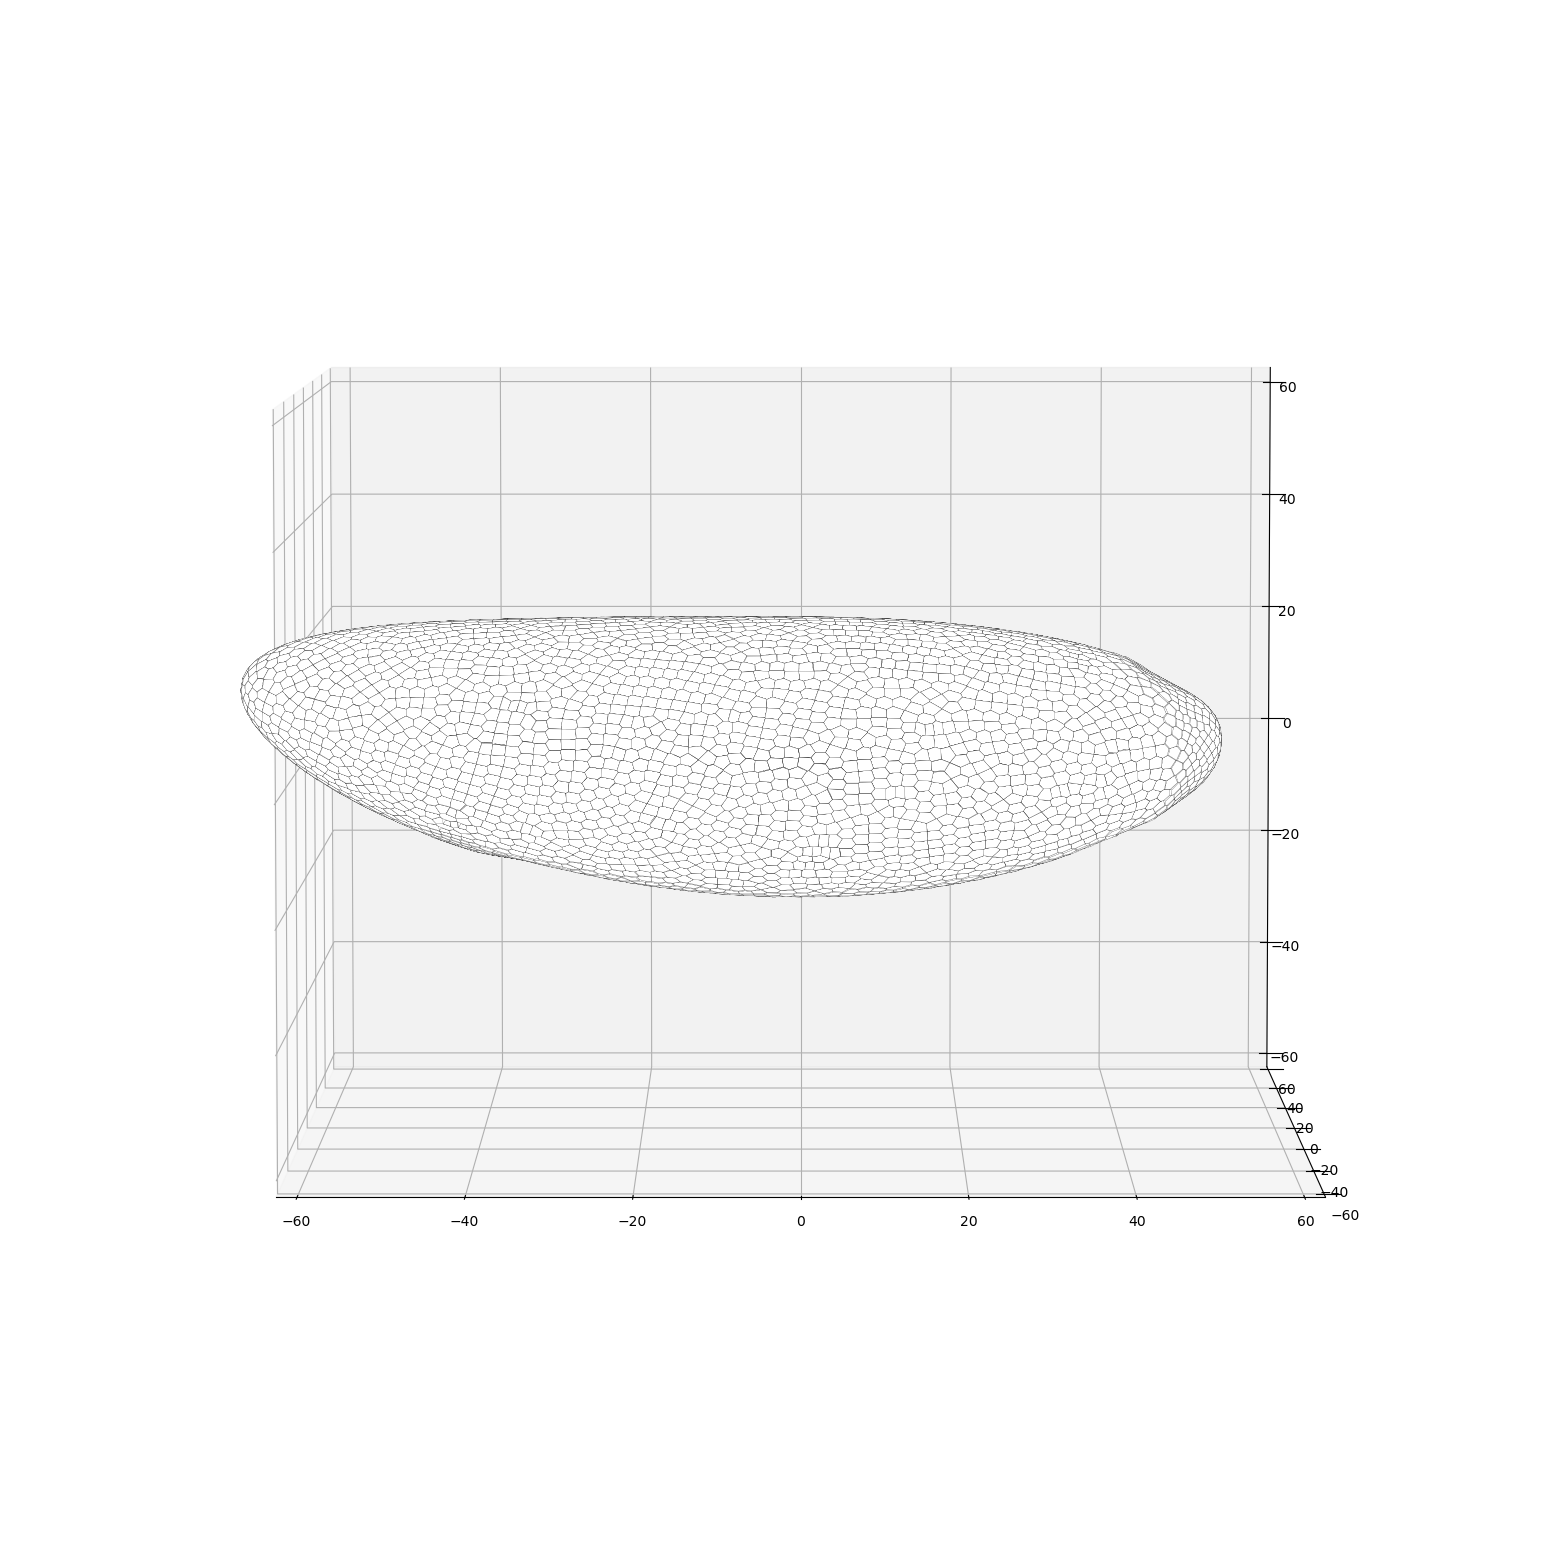

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

rng = np.random.default_rng(11)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# for each Voronoi cell, plot all the faces of the corresponding polygon
for vnoicell in voronoi[:5000]:
    faces = []
    # the vertices are the corner points of the Voronoi cell
    vertices = np.array(vnoicell['vertices'])
    # cycle through all faces of the polygon
    for face in vnoicell['faces']:
        faces.append(vertices[np.array(face['vertices'])])
        
    # join the faces into a 3D polygon
    polygon = Poly3DCollection(faces, alpha=1., 
                               facecolors="white",
                               linewidths=0.1,edgecolors='black')
    ax.add_collection3d(polygon)

plt.xlim(-60,60)
plt.ylim(-60,60)
ax.set_zlim(-60,60)

# set the view
ax.view_init(elev=5, azim=-90)
    
plt.show()

In [10]:
points.max(axis = 0)

array([52.465782, 23.320297, 23.32825 ], dtype=float32)

In [46]:
points = np.load('early_poss.npy')

tri = Voronoi(points)

# get neighbors
indptr, indices = tri.vertex_neighbor_vertices

nbs = []
# get neighbors for each point
for i in range(len(points)):
    nbs.append(indices[indptr[i]:indptr[i+1]])


new_points = []

seen_points = []

original_index = []

for i in range(len(points)):
    print(i/len(points), end='\r')
    new_points.append(points[i])
    random_color = np.random.rand(3)
    original_index.append(i) 
    for j in nbs[i]:
        if set([i, j]) in seen_points:
            continue
        new_points.append((points[i] + points[j]) / 2)
        seen_points.append(set([i, j]))
        original_index.append(i)

new_points = np.array(new_points)


In [15]:
# new_points


array([[ 22.953701  ,   0.24650294, -16.557964  ],
       [ 21.586704  ,  -0.11349684,   2.6884604 ],
       [ 21.893291  ,   1.7138588 ,   2.5508213 ],
       ...,
       [ -5.0137353 ,  22.032719  ,  -7.3438745 ],
       [ -6.032687  , -13.591119  ,  18.944372  ],
       [-32.05221   ,  20.289392  ,  -1.8309369 ]], dtype=float32)

In [27]:
newdel = Delaunay(new_points)

simplex = newdel.find_simplex(new_points[1])

In [23]:
indptr, indices = newdel.vertex_neighbor_vertices


pd_style = []

for k in range(new_points.shape[0]):
    nbs = indices[indptr[k]:indptr[k+1]]
    pd_style.append(len(nbs))
    for nb in nbs:
        new_points(nb)

38658

In [82]:
points = np.load('early_poss.npy')

cloud = pv.PolyData(points)
surf = cloud.delaunay_3d(alpha = 9999.)



# show the points
pl = pv.Plotter()
cloud2 = pv.PolyData(new_points)

pl.add_mesh(cloud2, point_size=5, color='green')
pl.add_mesh(cloud, point_size=5, color='red')
pl.add_mesh(surf,  show_edges=True,)
pl.show()


Widget(value='<iframe src="http://localhost:51087/index.html?ui=P_0x1f8eb201580_11&reconnect=auto" class="pyvi…

In [38]:
cloud = pv.PolyData(new_points)
surf = cloud.delaunay_3d(alpha = 9999.)


In [44]:
from numba import njit


@njit(parallel=True)
def do_da_thing(offsets, cells, surf_points,  points):
    currenti = 0

    scalar = []

    good_cells = []
    n_good = 0
    for offset in offsets:
        # print(currenti/len(offsets), n_good, end='\r')

        n_tri = cells[offset]
        tri = cells[(offset+1):(offset+n_tri+1)]

        has_broken = False
        for point in tri:
            sp = surf_points[point]
            for p in points:
                if np.allclose(sp, p):
                    scalar.append(p)
                    has_broken = True
                    break
            if has_broken:
                break

        if has_broken:
            good_cells.append(n_tri)
            for t in tri:
                good_cells.append(t)
            n_good += 1

        currenti += 1

good_cells = do_da_thing(surf.offset, surf.cells, surf.points, new_points)

c:\Users\jakob\miniconda3\envs\reworked\lib\site-packages\numba\core\typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_140\2462652661.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,

KeyboardInterrupt



In [69]:
surf.cells = np.array(good_cells)

array([   3,   35,   25, 2373,    3], dtype=int64)

In [62]:
points[closest]


array([ 25.296047 ,  17.125185 , -10.3861265], dtype=float32)

Not exactly looking perfect :(

![alt text](viz_screenshot.png)